In [1]:
import flair
import pandas as pd

In [2]:
from flair.data_fetcher import NLPTaskDataFetcher
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentLSTMEmbeddings, DocumentRNNEmbeddings, BertEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
from pathlib import Path
from flair.datasets import ClassificationCorpus
from flair.data import Corpus

In [3]:
data = pd.read_csv("train_sst.csv")#.sample(frac=1).drop_duplicates()
data = data[['label', 'text']] #.rename(columns={"v1":"label", "v2":"text"})

data['label'] = '__label__' + data['label'].astype(str)
data['text'] = data['text'].astype(str)
data.head()

,label,text
0,__label__positive,the rock is destined to be the st century new ...
1,__label__positive,the gorgeously elaborate continuation of the l...
2,__label__positive,singer composer bryan adams contributes slew o...
3,__label__neutral,you think by now america would have had enough...
4,__label__positive,yet the act is still charming here


In [4]:
data_dev = pd.read_csv("dev_sst.csv") #.sample(frac=1).drop_duplicates()
data_dev = data_dev[['label', 'text']] #.rename(columns={"v1":"label", "v2":"text"})
 
data_dev['label'] = '__label__' + data_dev['label'].astype(str)
data_dev.head()

,label,text
0,__label__positive,it lovely film with lovely performances by buy...
1,__label__neutral,no one goes unindicted here which is probably ...
2,__label__positive,and if you re not nearly moved to tears by cou...
3,__label__positive,warm funny engaging film
4,__label__positive,uses sharp humor and insight into human nature...


In [5]:
data_test = pd.read_csv("test_sst.csv") #.sample(frac=1).drop_duplicates()
data_test = data_test[['label', 'text']] #.rename(columns={"v1":"label", "v2":"text"})
 
data_test['label'] = '__label__' + data_test['label'].astype(str)
data_test.head()

,label,text
0,__label__neutral,effective but too tepid biopic
1,__label__positive,if you sometimes like to go to the movies to h...
2,__label__positive,emerges as something rare an issue movie that ...
3,__label__neutral,the film provides some great insight into the ...
4,__label__positive,offers that rare combination of entertainment ...


In [6]:
data.to_csv('train_sst_flair_format.csv', sep='\t', index = False, header = False)
data_dev.to_csv('dev_sst_flair_format.csv', sep='\t', index = False, header = False)
data_test.to_csv('test_sst_flair_format.csv', sep='\t', index = False, header = False)

print(data.shape)
print(data_dev.shape)
print(data_test.shape)

(8544, 2)
(1101, 2)
(2210, 2)


In [7]:
corpus: Corpus = ClassificationCorpus(Path('./'), 
                                      test_file = 'test_sst_flair_format.csv',
                                      dev_file='dev_sst_flair_format.csv', 
                                      train_file='train_sst_flair_format.csv')

2020-02-25 08:13:11,634 Reading data from .
2020-02-25 08:13:11,635 Train: train_sst_flair_format.csv
2020-02-25 08:13:11,635 Dev: dev_sst_flair_format.csv
2020-02-25 08:13:11,636 Test: test_sst_flair_format.csv


In [8]:
label_dict = corpus.make_label_dictionary()

2020-02-25 08:13:11,710 Computing label dictionary. Progress:


100%|██████████| 8503/8503 [00:02<00:00, 3859.65it/s]

2020-02-25 08:13:13,994 [b'positive', b'neutral', b'negative']


In [9]:
word_embeddings = [WordEmbeddings('glove')
                  # , FlairEmbeddings('news-forward-fast')
                  # , FlairEmbeddings('news-backward-fast')
                  , BertEmbeddings('bert-base-uncased'),
                  # , FlairEmbeddings('multi-backward')
                  ]

In [10]:
document_embeddings = DocumentRNNEmbeddings(word_embeddings, 
                                            hidden_size=512, 
                                            reproject_words=True, 
                                            reproject_words_dimension=256,
                                            rnn_type='LSTM',
                                           bidirectional = True)

In [11]:
classifier = TextClassifier(document_embeddings, label_dictionary=label_dict, multi_label=False)

In [12]:
trainer = ModelTrainer(classifier, corpus)

In [13]:
# 7. find learning rate
learning_rate_tsv = trainer.find_learning_rate('./', 'learning_rate.tsv')

2020-02-25 08:18:02,158 ----------------------------------------------------------------------------------------------------
2020-02-25 08:18:02,160 learning rate finder finished - plot learning_rate.tsv
2020-02-25 08:18:02,160 ----------------------------------------------------------------------------------------------------


Learning_rate plots are saved in learning_rate.png


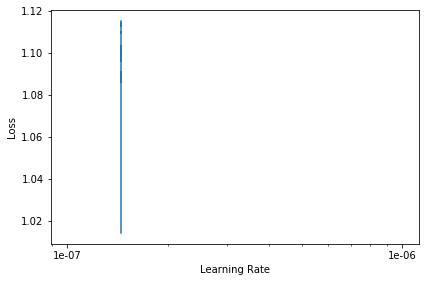

In [14]:
# 8. plot the learning rate finder curve
from flair.visual.training_curves import Plotter
plotter = Plotter()
plotter.plot_learning_rate(learning_rate_tsv)

In [15]:
trainer.train('./', 
              max_epochs=5,
              mini_batch_size = 32,
              train_with_dev=False)

2020-02-25 08:18:02,876 ----------------------------------------------------------------------------------------------------
2020-02-25 08:18:02,880 Model: "TextClassifier(
  (document_embeddings): DocumentRNNEmbeddings(
    (embeddings): StackedEmbeddings(
      (list_embedding_0): WordEmbeddings('glove')
      (list_embedding_1): BertEmbeddings(
        (model): BertModel(
          (embeddings): BertEmbeddings(
            (word_embeddings): Embedding(30522, 768, padding_idx=0)
            (position_embeddings): Embedding(512, 768)
            (token_type_embeddings): Embedding(2, 768)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (encoder): BertEncoder(
            (layer): ModuleList(
              (0): BertLayer(
                (attention): BertAttention(
                  (self): BertSelfAttention(
                    (query): Linear(in_features=768, out_features=768, bia

/home/vjhunjhunwala/.conda/envs/flair/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type DocumentRNNEmbeddings. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/vjhunjhunwala/.conda/envs/flair/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type StackedEmbeddings. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/vjhunjhunwala/.conda/envs/flair/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type WordEmbeddings. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/vjhunjhunwala/.conda/envs/flair/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type 

2020-02-25 08:31:49,956 ----------------------------------------------------------------------------------------------------
2020-02-25 08:31:52,970 epoch 2 - iter 0/266 - loss 0.96310091 - samples/sec: 296.24
2020-02-25 08:33:02,270 epoch 2 - iter 26/266 - loss 0.83576711 - samples/sec: 12.11
2020-02-25 08:34:16,183 epoch 2 - iter 52/266 - loss 0.81419644 - samples/sec: 11.28
2020-02-25 08:35:24,055 epoch 2 - iter 78/266 - loss 0.82145965 - samples/sec: 12.29
2020-02-25 08:36:35,868 epoch 2 - iter 104/266 - loss 0.82824258 - samples/sec: 11.66
2020-02-25 08:37:47,452 epoch 2 - iter 130/266 - loss 0.83338400 - samples/sec: 11.65
2020-02-25 08:38:55,799 epoch 2 - iter 156/266 - loss 0.83845137 - samples/sec: 12.26
2020-02-25 08:40:09,762 epoch 2 - iter 182/266 - loss 0.82765215 - samples/sec: 11.28
2020-02-25 08:41:24,540 epoch 2 - iter 208/266 - loss 0.82458345 - samples/sec: 11.20
2020-02-25 08:42:37,475 epoch 2 - iter 234/266 - loss 0.82280271 - samples/sec: 11.43
2020-02-25 08:43:50

{'test_score': 0.6945,
 'dev_score_history': [0.6293, 0.6166, 0.653, 0.6749, 0.6721],
 'train_loss_history': [0.9283136976392645,
  0.8190442190358513,
  0.7822414311699402,
  0.7504074902910935,
  0.7189613053000959],
 'dev_loss_history': [tensor(0.8331, device='cuda:0'),
  tensor(0.8868, device='cuda:0'),
  tensor(0.8787, device='cuda:0'),
  tensor(0.8803, device='cuda:0'),
  tensor(0.8418, device='cuda:0')]}

In [16]:
import flair
from flair.data import Sentence, Token

classifier = TextClassifier.load('./final-model.pt')
sentence = Sentence('A movie worth watching but not for kids')
classifier.predict(sentence)
print(sentence.labels)

2020-02-25 09:30:24,766 loading file ./final-model.pt
[negative (0.42701229453086853)]


In [17]:
classifier = TextClassifier.load('./final-model.pt')
sentence = Sentence('A movie worth watching but not for kids')
classifier.predict(sentence)
print(sentence.labels)

2020-02-25 09:30:26,215 loading file ./final-model.pt
[negative (0.42701229453086853)]


In [18]:
print(sentence.labels[0])

negative (0.42701229453086853)


In [27]:
import numpy as np
data_test_results = data_test
data_test_results['predicted'] = np.NaN

for idx, row in data_test.iterrows():
    sentence = Sentence(row['text'])
    classifier.predict(sentence)
    data_test_results.at[idx, 'predicted'] = sentence.labels[0]

In [28]:
data_test_results.iloc[0]

label                          __label__neutral
text             effective but too tepid biopic
predicted        negative (0.41626760363578796)
label_new                               neutral
predicted_new                          negative
Name: 0, dtype: object

In [29]:
data_test_results['label_new'] = data_test_results['label'].str.replace("__label__", "")
import re
regex = re.compile('[^a-zA-Z]')
for idx, row in data_test_results.iterrows():
    data_test_results.at[idx, 'predicted_new'] = regex.sub('', str(row['predicted']))
data_test_results.iloc[0]

label                          __label__neutral
text             effective but too tepid biopic
predicted        negative (0.41626760363578796)
label_new                               neutral
predicted_new                          negative
Name: 0, dtype: object

In [30]:
from sklearn.metrics import classification_report
print(classification_report(data_test_results['label_new'],data_test_results['predicted_new']))

              precision    recall  f1-score   support

    negative       0.65      0.87      0.74       912
     neutral       0.52      0.03      0.06       389
    positive       0.75      0.80      0.77       909

    accuracy                           0.69      2210
   macro avg       0.64      0.57      0.53      2210
weighted avg       0.67      0.69      0.64      2210



## Glove Embeddings, Epochs = 5, Test_F1_Macro = 0.459, Test_F1_Micro: 0.6237
## Glove,Flair, Flair Embeddings, Epochs = 5, Test_F1_Macro = 0.466, Test_F1_Micro: 0.600
## Glove,Bert base Embeddings, Epochs = 5, Test_F1_Macro = 0.52, Test_F1_Micro: 0.63
## Glove, Bert Base Embeddings, Bidirectional, Epochs = 5, Test_F1_Macro = 0.53, Test_F1_Micro: 0.64

## Appendix

In [23]:
"""label_dictionary = []
len_label_dict = []
text_dictionary = []
len_text_dict = []
for i in range(len(data)):
    #if label=="" :
    #    print('null')
    label_dictionary.append(data.loc[i,'label'])
    text_dictionary.append(data.loc[i,'text'])
    len_label_dict.append(len(data.loc[i,'label']))
    len_text_dict.append(len(data.loc[i,'text']))
    if(len(data.loc[i,'text']) == 1):
        print(i)
len(label_dictionary)"""

'label_dictionary = []\nlen_label_dict = []\ntext_dictionary = []\nlen_text_dict = []\nfor i in range(len(data)):\n    #if label=="" :\n    #    print(\'null\')\n    label_dictionary.append(data.loc[i,\'label\'])\n    text_dictionary.append(data.loc[i,\'text\'])\n    len_label_dict.append(len(data.loc[i,\'label\']))\n    len_text_dict.append(len(data.loc[i,\'text\']))\n    if(len(data.loc[i,\'text\']) == 1):\n        print(i)\nlen(label_dictionary)'

In [24]:
#pd.DataFrame({'labels':label_dictionary,'length':len_label_dict,'text':text_dictionary,'length_text':len_text_dict}).to_csv('lengths.csv')

In [25]:
#document_embeddings = document_embeddings.to(flair.device)

In [26]:
import torch
print(torch.cuda.is_available())

True
